<a href="https://colab.research.google.com/github/march250602/Covid19-tweet-sentiment-analysis/blob/main/Copy_of_CNN_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_train = pd.read_csv('/content/Corona_NLP_train.csv', encoding = 'latin')

df_test = pd.read_csv('/content/Corona_NLP_test.csv', encoding = 'latin')

In [ ]:
df_train

Text(0.5, 1.0, 'Distribution of sentiment in training data')

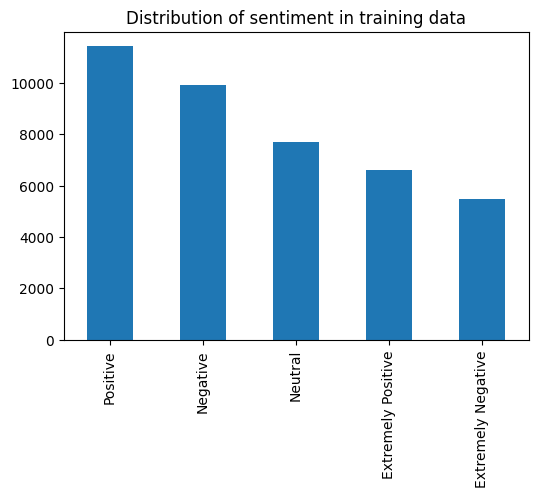

In [6]:
plt.figure(figsize = (6,4))
df_train.Sentiment.value_counts().plot(kind = 'bar')
plt.title('Distribution of sentiment in training data')

In [7]:
x = df_train['OriginalTweet']
y = df_train['Sentiment']

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.layers as layer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
import re
def text_cleaner(tweet):
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    return tweet

stop_words = stopwords.words('english')

X_c = x.apply(text_cleaner)
X_c.head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_c)

X = tokenizer.texts_to_sequences(X_c)
vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_c[18]))
print("\nAfter tokenizing :\n{}".format(X[18]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[18]))

Vocabulary size: 36117

Example:

Sentence:
Amazon Glitch Stymies Whole Foods, Fresh Grocery Deliveries ÂAs COVID- spread, weÂve seen significant increase people shopping online groceries,Â spokeswoman said statement. ÂToday resulted systems impact affecting ...

After tokenizing :
[423, 13610, 13611, 478, 742, 510, 7, 614, 11240, 1, 92, 1936, 262, 1200, 218, 8, 12, 13, 266, 245, 13612, 143, 1740, 9764, 3690, 1651, 107, 1303]

After padding :
[  423 13610 13611   478   742   510     7   614 11240     1    92  1936
   262  1200   218     8    12    13   266   245 13612   143  1740  9764
  3690  1651   107  1303     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [12]:
sentiments = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }
y = y.map(sentiments)
labels = ['Negative', 'Neutral', 'Positive']

In [13]:
X_test = df_test['OriginalTweet'].copy()
y_test = df_test['Sentiment'].copy()

X_test = X_test.apply(text_cleaner)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post', maxlen = X.shape[1])

y_test = y_test.map(sentiments)

In [14]:
def training_plotting_predicting(model, eps, bs, model_name):

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)

    model.compile(loss=SparseCategoricalCrossentropy(from_logits = False),
              optimizer='adam',metrics=['accuracy'])

    history = model.fit(X, y, epochs=eps,
                        validation_split=0.15, batch_size=bs,
                        callbacks = [callback])

    hist_model = pd.DataFrame(history.history)

    #Plot the loss and accuracy curves
    fig, ax = plt.subplots(2,1, figsize = (8,8))
    ax[0].plot(hist_model.loss, c = 'b')
    ax[0].plot(hist_model.val_loss, c = 'r')
    ax[0].set_title('Training and validation losses');
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(hist_model.accuracy, c = 'b')
    ax[1].plot(hist_model.val_accuracy, c = 'r')
    ax[1].set_title('Training and validation accuracies');
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='upper left')

    #Prediction
    pred = np.argmax(np.round(model.predict(X_test)),axis = 1)
    CNN_loss, CNN_acc = model.evaluate(X_test,y_test,verbose=0)
    print('Test loss: {}'.format(CNN_loss))
    print('Test Accuracy: {}'.format(CNN_acc))

    #Confustion matrix
    confm = confusion_matrix(y_test, pred)
    cm= pd.DataFrame(confm, index = [i for i in labels],
                    columns = [i for i in labels])

    plt.figure(figsize = (8,6))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix of ' + model_name)
    plt.show()

    return CNN_acc, cm

In [15]:
embedding_dim = 16
#Input size is 54x1
i= layer.Input(shape=(X.shape[1],),)
x = layer.Embedding(vocab_size, embedding_dim, input_length=X.shape[1])(i)

#Output of this next layer is (54-3+1,32) = (52,32)
x = layer.Conv1D(32, 3, activation='relu')(x)
#Output of this next layer is (52/2, 32) = (26,32)
x = layer.MaxPooling1D(2)(x)

#Output of this next layer is (26-3+1, 64) = (24,64)
x = layer.Conv1D(64, 3, activation='relu')(x)
#Output of this next layer is (24/2, 64) = (12,64)
x = layer.MaxPooling1D(2)(x)

#Output of this next layer is (12-3+1,128) = (10,128)
x = layer.Conv1D(128, 3, activation='relu')(x)
#Output of this next layer is (10/2,128) = (5,128)
x = layer.MaxPooling1D(2)(x)

#Output of this next layer is (1,128)
x = layer.GlobalMaxPooling1D()(x)
outputs = layer.Dense(3, activation='softmax')(x)
model_1 = tf.keras.Model(i, outputs)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 54)]              0         
                                                                 
 embedding (Embedding)       (None, 54, 16)            577872    
                                                                 
 conv1d (Conv1D)             (None, 52, 32)            1568      
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 12, 64)            0         
 g1D)                                                        

Epoch 1/15
1094/1094 [==============================] - 24s 21ms/step - loss: 0.6347 - accuracy: 0.7298 - val_loss: 0.4251 - val_accuracy: 0.8610
Epoch 2/15
1094/1094 [==============================] - 22s 20ms/step - loss: 0.3246 - accuracy: 0.8964 - val_loss: 0.3983 - val_accuracy: 0.8636
Epoch 3/15
119/119 [==============================] - 1s 3ms/step
Test loss: 0.5079684257507324
Test Accuracy: 0.8364928960800171


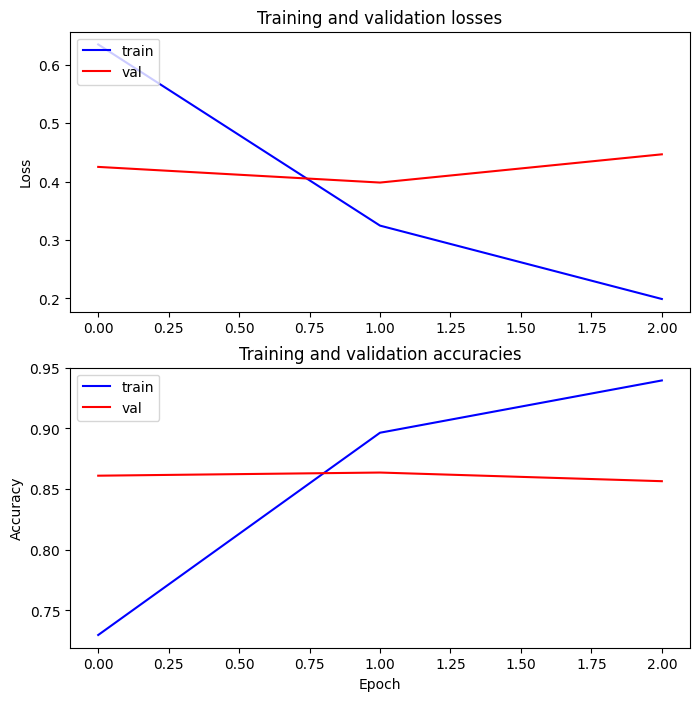

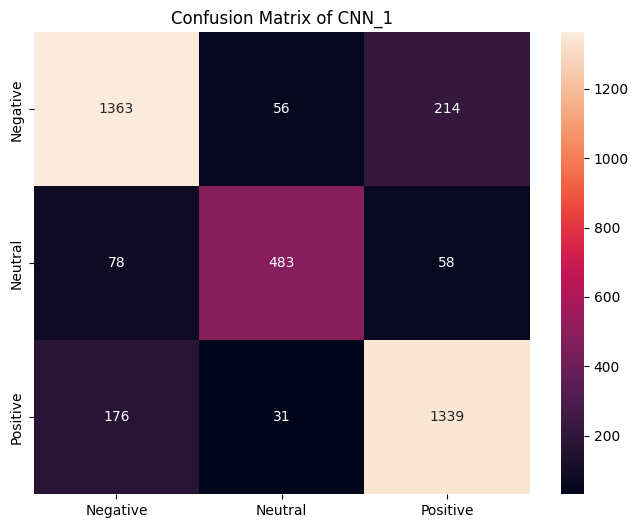

In [16]:
cnn1 = training_plotting_predicting(model_1, 15, 32, 'CNN_1')